In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install scorecardpy

# Load Data

In [3]:
df = pd.read_excel('german_credit_data.xlsx')
df = df.rename(columns={'Saving accounts' : 'Saving_accounts',
                        'Checking account' : 'Checking_account',
                        'Credit amount' : 'Credit_amount'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving_accounts   817 non-null    object
 6   Checking_account  606 non-null    object
 7   Credit_amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


Pengamatan\:
1. Data terdiri dari 1000 baris
2. Tampak beberapa kolom masih memiliki null/missing values (Non-Null Count < jumlah baris)
​
Keterangan features:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich) // nabung
6. Checking account (numeric, in DM - Deutsch Mark) // pengeluaran harian
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Missing Value

In [5]:
df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving_accounts     183
Checking_account    394
Credit_amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
df['Saving_accounts'].fillna('little', inplace=True)
df['Checking_account'].fillna(method = 'bfill', inplace=True)

In [7]:
df.isna().sum()

Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

## Duplicated Data

In [8]:
df.duplicated().sum()

0

## Outlier

In [9]:
from scipy import stats
nums = ['Age', 'Credit_amount', 'Duration']
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in nums:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 1000
Jumlah baris setelah memfilter outlier: 958


## Label Encoding

## Feature Selection

In [10]:
# Ubah Risk jadi 0 good, 1 bad
#variable selection based on IV
dt_s = sc.var_filter(df, y="Risk")

[INFO] filtering variables ...


In [11]:
dt_s

,Credit_amount,Purpose,Checking_account,Duration,Housing,Sex,Saving_accounts,Age,Risk
0,1169,radio/TV,little,6,own,male,little,67,0
1,5951,radio/TV,moderate,48,own,female,little,22,1
2,2096,education,little,12,own,male,little,49,0
3,7882,furniture/equipment,little,42,free,male,little,45,0
4,4870,car,little,24,free,male,little,53,1
...,...,...,...,...,...,...,...,...,...
995,1736,furniture/equipment,little,12,own,female,little,31,0
996,3857,car,little,30,own,male,little,40,0
997,804,radio/TV,little,12,own,male,little,38,0
998,1845,radio/TV,little,45,free,male,little,23,1


## WOE, IV

In [12]:
bins = sc.woebin(dt_s, y="Risk")

[INFO] creating woe binning ...


In [13]:
bins

{'Credit_amount':         variable              bin  count  count_distr  good  bad   badprob  \
 0  Credit_amount    [-inf,1400.0)    265     0.276618   183   82  0.309434   
 1  Credit_amount  [1400.0,1800.0)    105     0.109603    87   18  0.171429   
 2  Credit_amount  [1800.0,2000.0)     60     0.062630    39   21  0.350000   
 3  Credit_amount  [2000.0,4000.0)    321     0.335073   247   74  0.230530   
 4  Credit_amount  [4000.0,7800.0)    158     0.164927   100   58  0.367089   
 5  Credit_amount     [7800.0,inf)     49     0.051148    25   24  0.489796   
 
         woe    bin_iv  total_iv  breaks  is_special_values  
 0  0.096778  0.002643  0.144565  1400.0              False  
 1 -0.675992  0.042433  0.144565  1800.0              False  
 2  0.280506  0.005202  0.144565  2000.0              False  
 3 -0.305778  0.029218  0.144565  4000.0              False  
 4  0.354818  0.022192  0.144565  7800.0              False  
 5  0.858723  0.042878  0.144565     inf              Fa

In [14]:
breaks_adj = {
    'Age' : [19, 28, 38],
    'Duration' : [4, 12, 24, 26],
    'Credit_amount' : [250, 2238]
}
bins_adj = sc.woebin(dt_s, y="Risk", breaks_list=breaks_adj)

[INFO] creating woe binning ...


In [15]:
bins_adj

{'Credit_amount':         variable            bin  count  count_distr  good  bad   badprob  \
 0  Credit_amount  [-inf,2238.0)    478     0.498956   345  133  0.278243   
 1  Credit_amount   [2238.0,inf)    480     0.501044   336  144  0.300000   
 
         woe    bin_iv  total_iv  breaks  is_special_values  
 0 -0.053650  0.001420  0.002802  2238.0              False  
 1  0.052247  0.001383  0.002802     inf              False  ,
 'Purpose':   variable                                                bin  count  \
 0  Purpose                         radio/TV%,%vacation/others    282   
 1  Purpose                                                car    319   
 2  Purpose  business%,%furniture/equipment%,%domestic appl...    301   
 3  Purpose                                          education     56   
 
    count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
 0     0.294363   219   63  0.223404 -0.346392  0.032613  0.051092   
 1     0.332985   223   96  0.300940  0.05672

{'Credit_amount': <Figure size 432x288 with 2 Axes>,
 'Purpose': <Figure size 432x288 with 2 Axes>,
 'Checking_account': <Figure size 432x288 with 2 Axes>,
 'Duration': <Figure size 432x288 with 2 Axes>,
 'Housing': <Figure size 432x288 with 2 Axes>,
 'Sex': <Figure size 432x288 with 2 Axes>,
 'Saving_accounts': <Figure size 432x288 with 2 Axes>,
 'Age': <Figure size 432x288 with 2 Axes>}

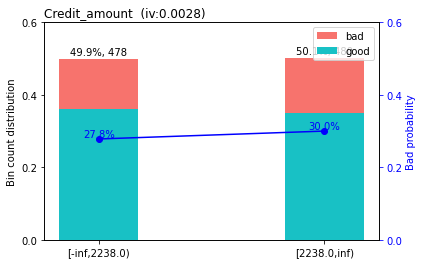

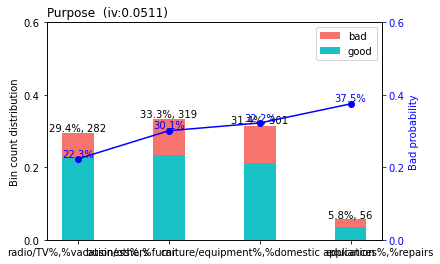

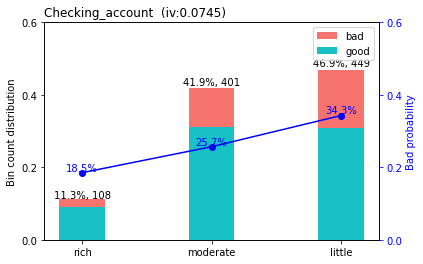

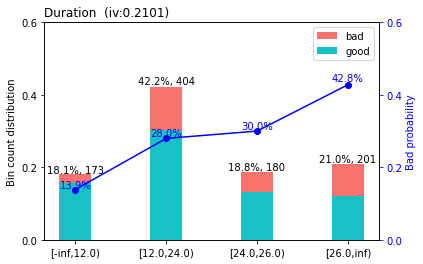

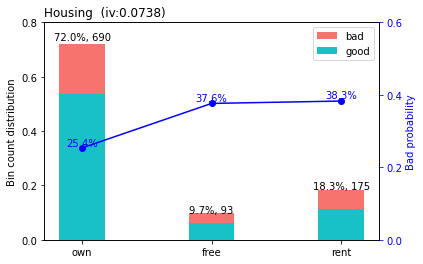

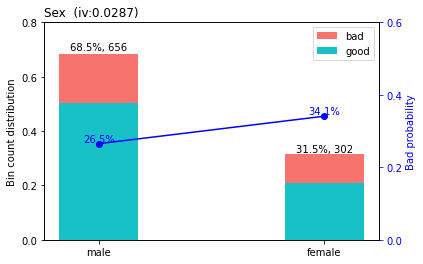

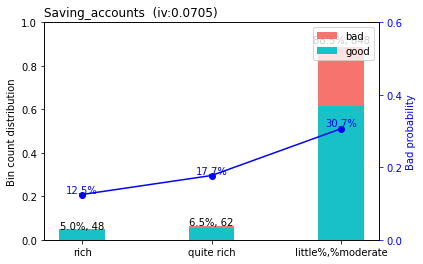

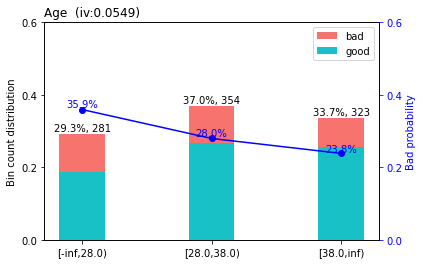

In [16]:
sc.woebin_plot(bins_adj)

In [17]:
### IV
info_value = sc.iv(df, y='Risk')
info_value

,variable,info_value
3,Duration,0.336061
9,Age,0.261470
2,Checking_account,0.074528
6,Housing,0.073786
8,Saving_accounts,0.070482
0,Credit_amount,0.054566
1,Purpose,0.051396
7,Sex,0.028689
5,Unnamed: 0,0.009123
4,Job,0.003580


## Split Data

In [18]:
X = dt_s.loc[:,dt_s.columns != 'Risk']
y = dt_s.loc[:,dt_s.columns == 'Risk']

In [19]:
train, test = sc.split_df(dt_s, 'Risk', ratio = 0.7).values()

In [20]:
##train & test WOE
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [21]:
ytrain = train_woe.loc[:,'Risk']
Xtrain = train_woe.loc[:,train_woe.columns != 'Risk']
ytest = test_woe.loc[:,'Risk']
Xtest = test_woe.loc[:,train_woe.columns != 'Risk']

## Modelling

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

def eval_classification(model):
    y_pred = model.predict(Xtest)
    y_pred_train = model.predict(Xtrain)
    y_pred_proba = model.predict_proba(Xtest)
    y_pred_proba_train = model.predict_proba(Xtrain)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(ytrain, y_pred_train))
    
    print("Precision (Test Set): %.2f" % precision_score(ytest, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(ytrain, y_pred_train))
    
    print("Recall (Test Set): %.2f" % recall_score(ytest, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(ytrain, y_pred_train))
    
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(ytrain, y_pred_train))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(ytest, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(ytrain, y_pred_proba_train[:, 1]))
    
    print(confusion_matrix(ytest, y_pred))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
eval_classification(lr)

Accuracy (Test Set): 0.71
Accuracy (Train Set): 0.73
Precision (Test Set): 0.50
Precision (Train Set): 0.61
Recall (Test Set): 0.08
Recall (Train Set): 0.19
F1-Score (Test Set): 0.14
F1-Score (Train Set): 0.29
AUC (test-proba): 0.66
AUC (train-proba): 0.71
[[197   7]
 [ 76   7]]


In [24]:
card = sc.scorecard(bins_adj, lr, Xtrain.columns)

train_score = sc.scorecard_ply(train, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)
test_score = sc.scorecard_ply(test, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)
score = sc.scorecard_ply(df, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)

In [25]:
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN   454.0,
 'Credit_amount':         variable            bin  points
 0  Credit_amount  [-inf,2238.0)    -4.0
 1  Credit_amount   [2238.0,inf)     4.0,
 'Purpose':   variable                                                bin  points
 2  Purpose                         radio/TV%,%vacation/others    20.0
 3  Purpose                                                car    -3.0
 4  Purpose  business%,%furniture/equipment%,%domestic appl...    -9.0
 5  Purpose                                          education   -23.0,
 'Checking_account':            variable       bin  points
 6  Checking_account      rich    42.0
 7  Checking_account  moderate    12.0
 8  Checking_account    little   -18.0,
 'Duration':     variable          bin  points
 9   Duration  [-inf,12.0)    72.0
 10  Duration  [12.0,24.0)     4.0
 11  Duration  [24.0,26.0)    -4.0
 12  Duration   [26.0,inf)   -47.0,
 'Housing':    variable   bin  points
 13  Housing   own

In [26]:
score

,Credit_amount_points,Purpose_points,Checking_account_points,Duration_points,Housing_points,Sex_points,Saving_accounts_points,Age_points,score
0,-4.0,20.0,-18.0,72.0,10.0,8.0,-5.0,8.0,545.0
1,4.0,20.0,12.0,-47.0,10.0,-16.0,-5.0,-10.0,422.0
2,-4.0,-23.0,-18.0,4.0,10.0,8.0,-5.0,8.0,434.0
3,4.0,-9.0,-18.0,-47.0,-22.0,8.0,-5.0,8.0,373.0
4,4.0,-3.0,-18.0,-4.0,-22.0,8.0,-5.0,8.0,422.0
...,...,...,...,...,...,...,...,...,...
995,-4.0,-9.0,-18.0,4.0,10.0,-16.0,-5.0,1.0,417.0
996,4.0,-3.0,-18.0,-47.0,10.0,8.0,-5.0,8.0,411.0
997,-4.0,20.0,-18.0,4.0,10.0,8.0,-5.0,8.0,477.0
998,-4.0,20.0,-18.0,-47.0,-22.0,8.0,-5.0,-10.0,376.0


In [27]:
df['score'] = score['score']

In [28]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,score
0,0,67,male,2,own,little,little,1169,6,radio/TV,good,545.0
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,422.0
2,2,49,male,1,own,little,little,2096,12,education,good,434.0
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,373.0
4,4,53,male,2,free,little,little,4870,24,car,bad,422.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,little,1736,12,furniture/equipment,good,417.0
996,996,40,male,3,own,little,little,3857,30,car,good,411.0
997,997,38,male,2,own,little,little,804,12,radio/TV,good,477.0
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad,376.0


In [29]:
df.to_csv('final_scorecard.csv')

In [30]:
df[(df['score']<=400) &
  (df['Risk']=='good')]

,Unnamed: 0,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,score
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,373.0
5,5,35,male,1,free,little,moderate,9055,36,education,good,382.0
14,14,28,female,2,rent,little,little,1403,15,car,good,390.0
17,17,25,male,2,own,little,little,8072,30,business,good,387.0
43,43,24,male,2,rent,moderate,little,6187,30,car,good,360.0
69,69,25,female,2,own,little,little,2394,36,radio/TV,good,392.0
70,70,30,female,2,own,little,little,8133,36,car,good,380.0
82,82,24,female,1,rent,moderate,little,1568,18,business,good,373.0
130,130,24,female,2,own,little,moderate,8487,48,car,good,399.0
148,148,28,male,2,own,little,little,5371,36,furniture/equipment,good,398.0


In [31]:
df[df['Risk']=='bad']

,Unnamed: 0,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,score
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,422.0
4,4,53,male,2,free,little,little,4870,24,car,bad,422.0
9,9,28,male,3,own,little,moderate,5234,30,car,bad,434.0
10,10,25,female,2,rent,little,moderate,1295,12,car,bad,409.0
11,11,24,female,2,rent,little,little,4308,48,business,bad,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
979,979,25,male,2,rent,moderate,moderate,1264,15,car,bad,433.0
980,980,49,male,2,own,little,moderate,8386,30,furniture/equipment,bad,435.0
981,981,33,male,3,rent,little,rich,4844,48,business,bad,425.0
983,983,26,male,2,own,little,little,8229,36,car,bad,393.0


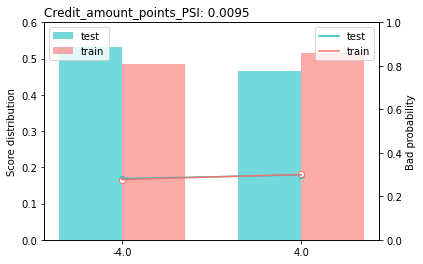

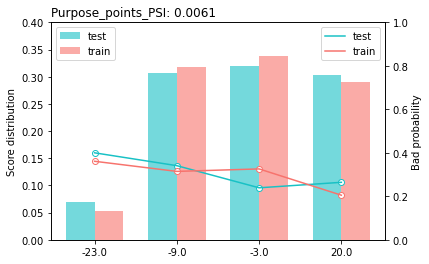

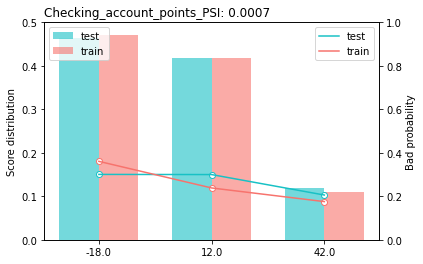

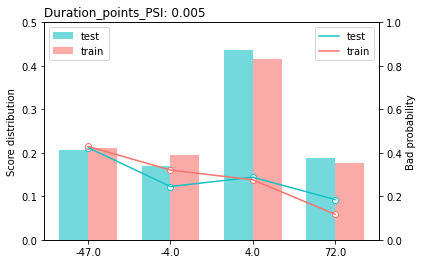

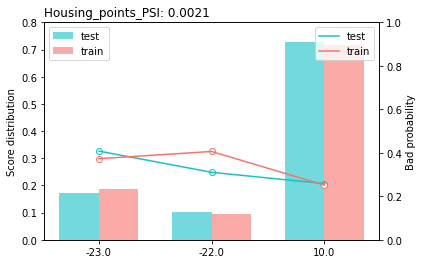

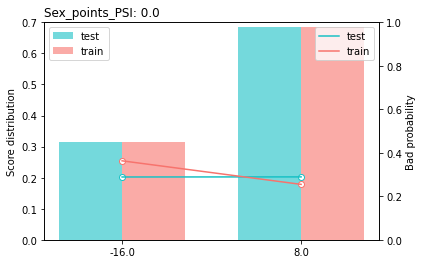

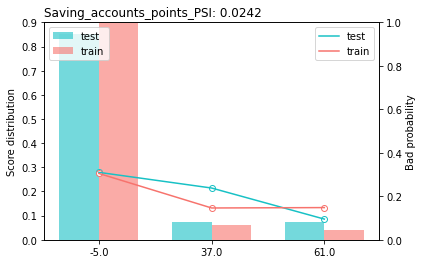

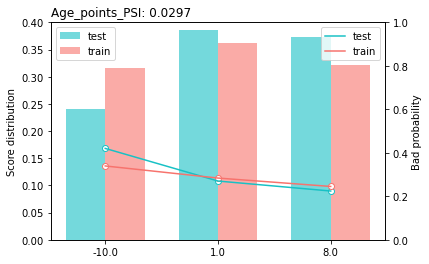

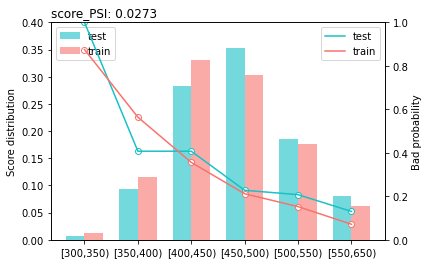

{'psi':                   variable       PSI
 0     Credit_amount_points  0.009516
 1           Purpose_points  0.006053
 2  Checking_account_points  0.000708
 3          Duration_points  0.005016
 4           Housing_points  0.002129
 5               Sex_points  0.000026
 6   Saving_accounts_points  0.024179
 7               Age_points  0.029728
 8                    score  0.027312,
 'pic': {'Credit_amount_points': <Figure size 432x288 with 2 Axes>,
  'Purpose_points': <Figure size 432x288 with 2 Axes>,
  'Checking_account_points': <Figure size 432x288 with 2 Axes>,
  'Duration_points': <Figure size 432x288 with 2 Axes>,
  'Housing_points': <Figure size 432x288 with 2 Axes>,
  'Sex_points': <Figure size 432x288 with 2 Axes>,
  'Saving_accounts_points': <Figure size 432x288 with 2 Axes>,
  'Age_points': <Figure size 432x288 with 2 Axes>,
  'score': <Figure size 432x288 with 2 Axes>}}

In [32]:
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':ytrain, 'test':ytest}
)